In [89]:
from pathlib import Path
import dill
import pyro
from tqdm.notebook import tqdm

import numpy as np
import torch
from torch.distributions.gamma import Gamma
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from scripts.lga.utils import *



In [199]:
checkpoint_dir = Path.cwd().resolve() / "checkpoints"

n_samples = 800

start_day = 4
end_day = 31

nominal_days = [
    1,2,3,4,5,7,9,
    10,12,13,14,15,16,
    20,24,25,26,27,28,29
]

failure_days = [
    6,8,
    11,17,18,19,
    21,22,23,30,31
]

is_valid_day = lambda x: start_day <= x <= end_day
nominal_days = list(filter(is_valid_day, nominal_days))
failure_days = list(filter(is_valid_day, failure_days))

# print(nominal_days, failure_days)

all_service_time_samples = {
    "failure": np.empty(shape=(len(failure_days), n_samples)),
    "nominal": np.empty(shape=(len(nominal_days), n_samples)),
}

idx = {
    "failure": 0,
    "nominal": 0
}

for day in tqdm(range(start_day, end_day+1)):
    
    nominal = day in nominal_days
    group = "nominal" if nominal else "failure"
    day_dir = checkpoint_dir / f"[LGA]_{group}_[2019-07-{day:02d}]"
    output_dict_path = day_dir / "final/output_dict.pkl"
    # guide_path = day_dir / "900/guide.pth"

    with open(output_dict_path, 'rb') as f:
        output_dict = dill.load(f)

    pyro.clear_param_store()  # avoid leaking parameters across runs
    pyro.enable_validation(True)
    pyro.set_rng_seed(1)

    model = output_dict["model"]
    guide = output_dict["guide"]
    states = output_dict["states"]
    dt = output_dict["dt"]

    # guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
    # guide.load_state_dict()
    
    # print(guide)

    with pyro.plate("samples", n_samples, dim=-1):
        posterior_samples = guide(states, dt)

    for key, samples in posterior_samples.items():
        posterior_samples[key] = samples.detach().cpu().numpy()

    service_time_samples = posterior_samples["LGA_0_mean_service_time"]

    all_service_time_samples[group][idx[group]] = service_time_samples
    # turnaround_time_samples = posterior_samples["LGA_0_mean_turnaround_time"]
    # base_cancel_prob_samples = np.exp(-posterior_samples["LGA_0_base_cancel_neg_logprob"])
    # initial_aircraft_samples = np.exp(posterior_samples["LGA_log_initial_available_aircraft"])

    idx[group] += 1


for group, samples in all_service_time_samples.items():
    all_service_time_samples[group] = samples.flatten()

# print(all_service_time_samples)
print({g: s.shape for g, s in all_service_time_samples.items()})
print({g: s.mean() for g, s in all_service_time_samples.items()})


  0%|          | 0/28 [00:00<?, ?it/s]

{'failure': (8800,), 'nominal': (13600,)}
{'failure': 0.017396456605902957, 'nominal': 0.007912883521126145}


/var/folders/7r/dc0lww4500zgz6xz8bvdkhd00000gn/T/ipykernel_31652/2396182384.py:92: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


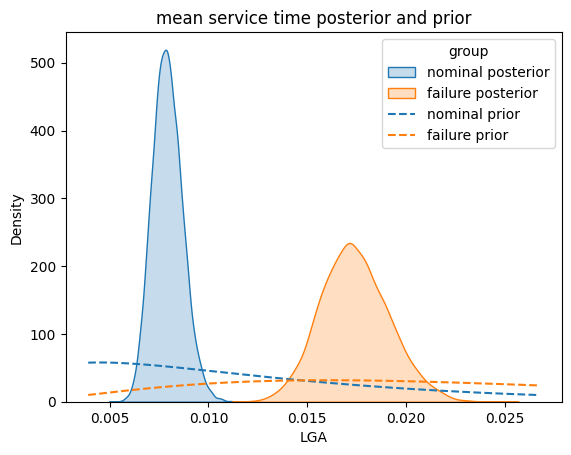

In [204]:
plotting_df = {}
groups = ("nominal", "failure")

palette = {
    'nominal posterior': "tab:blue", 'failure posterior': "tab:orange",
    'nominal prior': "tab:blue", 'failure prior': "tab:orange",
} 

# def clean(s):
#     return s[~np.isfinite(s)]

fig, ax = plt.subplots()

for group in groups:

    plotting_df[group] = pd.DataFrame(
        {
            "LGA": all_service_time_samples[group],
            "group": f"{group} posterior",
        },
    ) 
    
    # sns.histplot(
    #     x="LGA",
    #     data=plotting_df[group],
    #     ax=ax,
    #     bins=64,
    #     stat="density",
    #     # shrink=0.8,
    #     hue="group",
    #     palette=palette,
    #     edgecolor='none',
    #     label=f"{group} posterior",
    #     # kde=True,
    # )

    sns.kdeplot(
        x="LGA",
        data=plotting_df[group],
        ax=ax,
        hue="group",
        palette=palette,
        label=f"{group} posterior",
        fill=True,
    )

# xmin = min(np.concatenate([all_service_time_samples[group] for group in groups]))
# xmax = max(np.concatenate([all_service_time_samples[group] for group in groups]))
xmin, xmax = ax.get_xlim()
xs = np.arange(xmin, xmax, 0.0001)

def _gamma_dist_from_mean_std(mean, std):
    # std**2 = shape/rate**2
    # mean = shape/rate
    shape = (mean/std)**2
    rate = mean/std**2
    return Gamma(
        torch.tensor(shape),
        torch.tensor(rate)
    )

prior = {
    "nominal": _gamma_dist_from_mean_std(0.0125, 0.01),
    "failure": _gamma_dist_from_mean_std(0.025, 0.015),
}

for group, dist in prior.items():

    ys = dist.log_prob(xs).exp()

    plotting_df[group] = pd.DataFrame(
        {
            "x": xs,
            "y": ys,
            "group": f"{group} prior",
        },
    ) 

    sns.lineplot(
        x="x",
        y="y",
        data=plotting_df[group],
        hue="group",
        palette=palette,
        linestyle='dashed',
        # label=f"{group} prior density",
        ax=ax,
    )

ax.set_title("mean service time posterior and prior")

fig.show()